In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset

In [14]:
# Calling in a English/French dataset from HuggingFace
dataset = load_dataset("kaitchup/opus-English-to-French")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/897747 [00:00<?, ? examples/s]

In [15]:
# Unpacking the two datasets into the train and val Pandas DataFrames
# to later be concatenated into one DataFrame for preprocessing
train_df, val_df = pd.DataFrame(dataset["train"]), pd.DataFrame(dataset["validation"])

In [16]:
# Concatenating the train_df and val_df into one df to perform preprocessing
# (i.e. tokenization, seperating English and French text into seperate columns,
# EDA, remvoing unnecessary characters, etc.)
df = pd.concat([train_df, val_df])
df

,text
0,The time now is 05:08 . ###>The time now is 05...
1,This Regulation shall enter into force on the ...
2,"Hello, what's that? ###>Qu'est-ce que c'est qu..."
3,And then I will teach you everything i know. #...
4,Did you find something? ###>Par ici !
...,...
1995,"Of course, those responsible for this situatio..."
1996,Priority 2 ###>Axe 2
1997,Agree to disseminate widely the results of the...
1998,Following Public Notice CRTC 1995-10 dated 20 ...


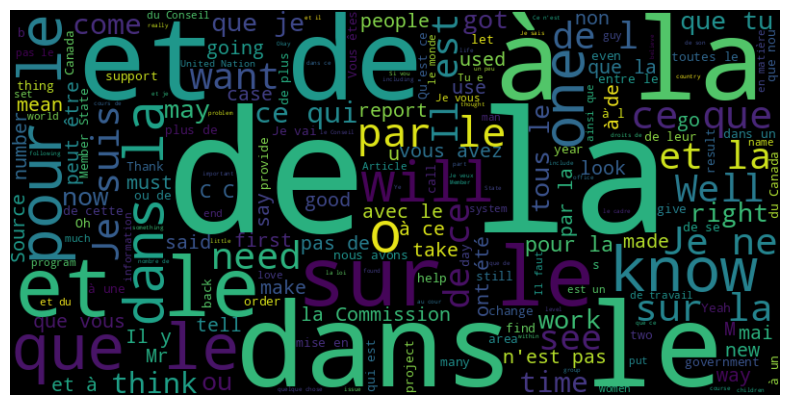

In [70]:
# Creating a wordcloud to get a visual of the most used words

text = ' '.join([t for t in df['text']])

wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
# Tokenization to give each word their own unique index (i.e. "I love the
# weekends" would be 1: "i", 2: "love", 3: "the", 4: "weekends")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [18]:
# Convert text to sequences of integers (i.e. "I love the weekends"
# would be converted to [1,2,3,4])
sequences = tokenizer.texts_to_sequences(df['text'])

In [19]:
# Padding sequences to a fixed length
max_length = 50
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [20]:
# Now we will split the "text" column into two seperate columns being
# "english" and "french"

# Split 'text' column based on "###" separator
df[['english', 'french']] = df['text'].str.split('###>', expand=True)

# Remove leading and trailing whitespace from 'french' column
df['french'] = df['french'].str.strip()

# Dropping the 'text' column from df now that we have it split between
# two different columns
df.drop(columns=['text'], inplace=True)

# Display the DataFrame with separated columns
df

,english,french
0,The time now is 05:08 .,The time now is 05:05 .
1,This Regulation shall enter into force on the ...,Le présent règlement entre en vigueur le septi...
2,"Hello, what's that?",Qu'est-ce que c'est que ça ?
3,And then I will teach you everything i know.,"Et alors, je t'apprendrai tout ce que je sais."
4,Did you find something?,Par ici !
...,...,...
1995,"Of course, those responsible for this situatio...",Il va de soi qu'il faut incriminer les politiq...
1996,Priority 2,Axe 2
1997,Agree to disseminate widely the results of the...,Décident de diffuser largement les résultats d...
1998,Following Public Notice CRTC 1995-10 dated 20 ...,À la suite de l'avis public CRTC 1995-10 du 20...


In [21]:
# Creating a regex function that will remove punctuation

# Define a regex pattern to match punctuation
pattern = r'[^\w\s]'

# Define a function to remove punctuation using regex
def remove_punctuation_regex(text):
    return re.sub(pattern, '', str(text))

# Apply the function to the 'english' and 'french' columns
df['english'] = df['english'].apply(remove_punctuation_regex)
df['french'] = df['french'].apply(remove_punctuation_regex)

In [22]:
df

,english,french
0,The time now is 0508,The time now is 0505
1,This Regulation shall enter into force on the ...,Le présent règlement entre en vigueur le septi...
2,Hello whats that,Questce que cest que ça
3,And then I will teach you everything i know,Et alors je tapprendrai tout ce que je sais
4,Did you find something,Par ici
...,...,...
1995,Of course those responsible for this situation...,Il va de soi quil faut incriminer les politiqu...
1996,Priority 2,Axe 2
1997,Agree to disseminate widely the results of the...,Décident de diffuser largement les résultats d...
1998,Following Public Notice CRTC 199510 dated 20 J...,À la suite de lavis public CRTC 199510 du 20 j...


In [23]:
# Splitting the dataframe into train and test df to later run our
# neural networks on

test_size = 0.2
random_state = 0

X = df['english']
y = df['french']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=random_state
)

In [24]:
print(
    f"{X_train.shape = }",
    f"\n{X_test.shape = }",
    f"\n{y_train.shape = }",
    f"\n{y_test.shape = }",
)

X_train.shape = (719797,) 
X_test.shape = (179950,) 
y_train.shape = (719797,) 
y_test.shape = (179950,)


In [26]:
num_words_eng = len(tokenizer.word_index) + 1  # Example: 10,000 unique words in English vocabulary
embedding_dim = 100    # Example: Embedding space dimensionality of 100
max_length = 50        # Example: Maximum length of English input sequences is 50
latent_dim = 200

In [29]:
inputs = tf.keras.layers.Input(shape=(max_length,))

## Add an Embedding layer to the encoder model:
## - input_dim: Number of unique words in the input language
## - output_dim: Dimensionality of the embedding space
## - input_shape: Maximum length of input sequences
embedding_layer = tf.keras.layers.Embedding(input_dim=num_words_eng, output_dim=embedding_dim)(inputs)

# Add an LSTM layer to the encoder model:
# - latent_dim: Dimensionality of the LSTM layer's output space (number of memory cells or units)
# - return_state=True: Ensures that the LSTM layer returns the final hidden state and cell state,
#                      which are important for passing information between encoder and decoder
lstm_layer, state_h, state_c = tf.keras.layers.LSTM(latent_dim, return_state=True)(embedding_layer)

encoder_model1 = tf.keras.models.Model(inputs=inputs, outputs=[lstm_layer, state_h, state_c])